# **<center> <span style="color:crimson;font-family:Lucida Console;"> TITANIC SURVIVAL  </span> </center>**

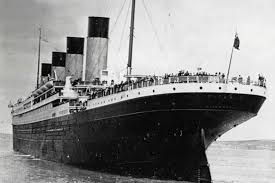

## **Let's get started!**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

* **Load train and test data sets**

In [ ]:
#load data set
train=pd.read_csv("../input/titanic/train.csv")
test=pd.read_csv("../input/titanic/test.csv")
IDtest=test["PassengerId"]

* **A quick look at our data**

In [ ]:
train.head()

In [ ]:
train.info()

**> The meaning of each attribute is the following:**

* PassengerId: the ID given to each passenger,
* Survived: the target attribute (1 for passengers who survived, 0 for those who didn't),
* Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd class),
* Name, Sex, Age: self-explanatory,
* SibSp: Number of siblings & spouses aboard the Titanic,
* Parch: Number of parents & children aboard the Titanic,
* Ticket: Ticket number,
* Fare: Passenger fare (in pounds),
* Cabin: Passenger's cabin number, and
* Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

*'PassengerId' is unique to each passenger*

In [ ]:
train.dtypes

* ### Outlier detection 


In [ ]:
#outlier detection
#tukey method

def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

Tukey's rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5IQR, or above Q3 + 1.5IQR.

Here, the code detects outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, considered outliers as rows that have at least two outlied numerical values.

In [ ]:
# Show the outliers rows
train.loc[Outliers_to_drop]

Here, we detected 10 outliers. PassengerId 29, 89, 342 have very high ticket fare while the rest have high SibSp value. Hence, we drop these.

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

* Join train and test datasets in order to obtain the same number of features during categorical conversion

In [ ]:
# Joining train and test data set
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

* Let's take a closer look at the missing values:

In [ ]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

In [ ]:
# Infos
train.info()
train.isnull().sum()

In [ ]:
train.head()

In [ ]:
missing_counts = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()*100/train.shape[0]).sort_values(ascending = False)

missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
display(missing_df.head().style.background_gradient(cmap = 'Reds', axis = 0))

While replacing missing values in the 'Age' and 'Embarked' columns won't be that difficult. However, we will probably have to discard the 'Cabin' attribute since more than 75% of all values are missing.

* Let's look at the statistical summary of the numerical attributes

In [ ]:
train.describe()

**Important things to note are:**
* Mean age is approx 30 years old, while the median is 28.
* Mean fair is £31.121
* Only 38% of passenegers survived.
* The median of both, SibSp and Parch, is 0 which indicates that most passengers were alone.

Let's visualize the differences in scales,by plotting a histogram for each numerical attribute.

In [ ]:
num_atts = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train[num_atts].hist(figsize = (15, 6), color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5, layout = (2, 3));

**It can be observed that most passengers:**
* were young (age < 40)
* boarded the ship alone (SibSp and Parch is 0)
* paid a low fare
* boarded in the 3rd class

<hr>

# 1. Feature Analysis
## **1.1 NUMERICAL VALUES**

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

> Only fare feature seems to have a significative corelation with the survival probability.

> Let's explore all these features to find further corelation with the survival and subpopulation of these features.

###  **1.11 SibSp**


In [ ]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6, palette="vlag" )
g.despine(left=True)
g = g.set_ylabels("survival probability")

> Single passengers (0 SibSP) or passengers having 1-2 relatives on board (SibSP 1 or 2) have more chance to survive while it seems that passengers having a lot of siblings/spouses have less chance to survive.

### **1.12 Parch**

In [ ]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , 
palette = "pastel")
g.despine(left=True)
g = g.set_ylabels("survival probability")


>  Small families (Parch 1,2) have more chance to survive when compared to single (parch 0), medium(parch 3,4) and large family(parch 5)

> **NOTE:** There is an important standard deviation in the survival of passengers with 3 parents/children



In [ ]:
alone = train[(train['SibSp'] == 0) & (train['Parch'] == 0)]
not_alone = train[(train['SibSp'] != 0) | (train['Parch'] != 0)]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Survived', data = alone,  palette = 'Blues', ax = ax1) 
ax1.set_title('Count of Alone (non-)Survivors')
ax1.set_xlabel('')
ax1.set_xticklabels(['Deceased', 'Survived'])
ax1.set_ylabel('Number of Passengers')

sns.countplot(x = 'Survived', data = not_alone,  palette = 'Blues', ax = ax2) 
ax2.set_title('Count of (non-)Survivors with Family Onboard')
ax2.set_xlabel('')
ax2.set_xticklabels(['Deceased', 'Survived'])
ax2.set_ylabel('Number of Passengers')

plt.tight_layout();

> Hence we can say that having 1 to 2 relatives on board can actually increase your chances of survival.

### **1.13 Age**

In [ ]:
men = train[train['Sex']  == 'male']
women = train[train['Sex']  == 'female']

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (13, 4))

sns.distplot(train[train['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax1, kde = False)
sns.distplot(train[train['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax1, kde = False)
ax1.legend()
ax1.set_title('Age Distribution - All Passengers')

sns.distplot(women[women['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax2, kde = False)
sns.distplot(women[women['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax2, kde = False)
ax2.legend()
ax2.set_title('Age Distribution - Women')

sns.distplot(men[men['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax3, kde = False)
sns.distplot(men[men['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax3, kde = False)
ax3.legend()
ax3.set_title('Age Distribution - Men')

plt.tight_layout();

> It is evident that different age groups had very different survival rates. For instance, both genders display a higher probability of survival between the ages of 15 and 45. Also, the spike at young ages (0-4) shows that infants and young children have higher odds of survival.We also see that passengers between 60-80 have less survived.

> So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

> It seems that very young passengers have more chance to survive.

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

> When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

### **1.14 Fare**

In [ ]:
dataset["Fare"].isnull().sum()

In [ ]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

> Since we have one missing value , I decided to fill it with the median value which will not have an important effect on the prediction.

In [ ]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

> As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

> In this case, it is better to transform it with the log function to reduce this skew.

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

> Skewness is clearly reduced after the log transformation

One would assume that fare is closely related to class. Let's plot a boxplot for the distribution of Fare values across classes and a histogram for survival:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(x = 'Pclass', y = 'Fare', data = train, palette = 'tab20', ax = ax1)
ax1.set_title('Distribution of Fares by Class')

sns.distplot(train[train['Survived'] == 1]['Fare'], label = 'Survived', ax = ax2)
sns.distplot(train[train['Survived'] == 0]['Fare'], label = 'Not Survived', ax = ax2)
ax2.set_title('Distribution of Fares for (non-)Survivors')
ax2.set_xlim([-20, 200])
ax2.legend();

It's not a surprise that people in class 1 paid more than the other two classes.

## **1.2 CATEGORICAL VALUES**

### **1.21 Gender**

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 4))

sns.countplot(x = 'Sex', hue = 'Survived', data = train,  palette = 'tab20', ax = ax1) 
ax1.set_title('Count of (non-)Survivors by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of Passenger')
ax1.legend(labels = ['Deceased', 'Survived'])

sns.barplot(x = 'Sex', y = 'Survived', data = train,  palette = ['#94BFA7', '#FFC49B'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Survival Rate');

In [ ]:
train[["Sex","Survived"]].groupby('Sex').mean()

There were more men than women on board. However, more women survived the shipwreck (the survival rate is almost 75% for women compared to only 20% for men!).Hence we can say that, "women and children first" protocol was implemented for boarding lifeboats.
So Gender might play an important role in the prediction of the survival.

### **1.22 Pclass**


In [ ]:
print ('Number of passengers in each class:')
train['Pclass'].value_counts()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Pclass', hue = 'Survived', data = train,  palette = 'tab20', ax = ax1) 
ax1.legend(['Deceased', 'Survived'])
ax1.set_title('Count of (non-)Survivors by Class')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Pclass', y = 'Survived', data = train,  palette = ['#C98BB9', '#F7D4BC', '#B5E2FA'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_ylabel('Survival Rate');

> More than 50% of passengers boarded in the 3rd class. Nevertheless, survival favours the wealthy as shown in the right figure (the survival rate increases as we move from 3rd to 1st class).

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   height=6, kind="bar", palette="rocket")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> This trend is conserved when we look at both male and female passengers.

### **1.23 PORT OF EMBARKATION**

In [ ]:
dataset["Embarked"].isnull().sum()

In [ ]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).

In [ ]:
sns.countplot(x = 'Embarked', hue = 'Survived', data = train,  palette = 'tab20') 
plt.ylabel('Number of Passenger')
plt.title('Count of (non-)Survivors by Port of Embarkation')
plt.legend(['Deceased', 'Survived']);

In [ ]:
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                   height=6, kind="bar", palette="Blues")
g.despine(left=True)
g = g.set_ylabels("survival probability")

> From the above plot we can see that passengers coming from Cherbourg (C) have more chance to survive.

Maybe the proportion of first class passengers is higher for those who came from Cherbourg (C) than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

In [ ]:
# Explore Pclass vs Embarked 
g = sns.catplot("Pclass", col="Embarked",  data=train,
                   height=6, kind="count", palette="YlOrBr")
g.despine(left=True)
g = g.set_ylabels("Count")

> Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

> Maybe we can say that first class passengers were prioritised during the evacuation due to their influence.

## **2. Filling missing Values**



### **2.1 AGE**

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")


Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [ ]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [ ]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

### **2.2 Fare**

In [ ]:
dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

## **3. FEATURE ENGINEERING**
### **3.1 NAME/TITLE**

In [ ]:
dataset["Name"].head()

The Name feature contains information on passenger's title.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [ ]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.



In [ ]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [ ]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [ ]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

We have already seen that women (Mrs or Miss) had higher odds of survival. Now here, notice that Masters and people with a Rare Title have indeed a higher chance of survival compared to 'common' men (Mr).

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### **3.2 FAMILY SIZE**

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [ ]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

In [ ]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset, kind='bar', palette='Blues')
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.

We create 4 categories of family size.

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [ ]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar",palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")

Catplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [ ]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [ ]:
dataset.head()

In [ ]:
dataset["Cabin"].head()

In [ ]:
dataset["Cabin"].describe()

In [ ]:
dataset["Cabin"].isnull().sum()

The Cabin feature column contains 292 values and 1007 missing values.

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

In [ ]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

In [ ]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### **3.4 TICKET**

In [ ]:
dataset["Ticket"].head()

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So let's replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
        #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket

dataset["Ticket"].head()

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [ ]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

## **4. MODELING**

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [ ]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

### **4.1 Simple Modelling**

#### **Cross Validate Model**

Let's compare popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

So we choose SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

#### **4.12 Hyperparameter tunning for best models**

grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

In [ ]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

In [ ]:
gsadaDTC.best_score_

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

#### **4.13 Plot learning curves**
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

#### **4.14 Feature importance of tree based classifiers**

In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

plot the feature importance for the 4 tree based classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).

We note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_2', 'Age' and 'Sex'.

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

We can say that:

* Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

* Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

* Age and Title_1 (Master) refer to the age of passengers.

* Fsize, LargeF, MedF, Single refer to the size of the passenger family.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.**

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

### **4.2 Ensemble modeling**

#### **4.21 Combining models**

A voting classifier to combine the predictions coming from the 5 classifiers.

Pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### **4.3 Prediction**

#### **4.31 Predict and Submit results**

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

If you liked the notebook then do upvote. It really does motivate!